<a href="https://colab.research.google.com/github/Luisgcattelan/cmip6/blob/main/tas_CMIP6_pt_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dados públicos do Google Cloud CMIP6: exemplo básico de Python

Este bloco de notas mostra como consultar o catálogo e carregar os dados usando python. Baseado no código disponiblizado pelo professor Reinaldo.

In [6]:
#Instalar bibliotecas necessárias e suas configurações
!pip install --upgrade  xarray zarr gcsfs cftime nc-time-axis 
!apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely;
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from matplotlib.axes import Axes
import cartopy
xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams['figure.figsize'] = 12, 6
fig = plt.figure(figsize=(15, 8))

Requirement already up-to-date: xarray in /usr/local/lib/python3.7/dist-packages (0.17.0)
Requirement already up-to-date: zarr in /usr/local/lib/python3.7/dist-packages (2.7.0)
Requirement already up-to-date: gcsfs in /usr/local/lib/python3.7/dist-packages (0.7.2)
Requirement already up-to-date: cftime in /usr/local/lib/python3.7/dist-packages (1.4.1)
Requirement already up-to-date: nc-time-axis in /usr/local/lib/python3.7/dist-packages (1.2.0)
Uninstalling Shapely-1.7.1:
  Successfully uninstalled Shapely-1.7.1
  Using cached https://files.pythonhosted.org/packages/42/f3/0e1bc2c4f15e05e30c6b99322b9ddaa2babb3f43bc7df2698efdc1553439/Shapely-1.7.1.tar.gz
Skipping wheel build for shapely, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for shapely ... done


ModuleNotFoundError: ignored

## Navegar no Catálogo
O catálogo de dados é armazenado como um arquivo CSV. Aqui nós lemos com o Pandas.

In [4]:
lista_de_modelos = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
modelos=lista_de_modelos.query("table_id=='Amon' | table_id=='fx'" )
modelos=modelos.query("variable_id=='tas' | variable_id=='pr'| variable_id=='areacella' ")
%load_ext google.colab.data_table
modelos.iloc[0:21000]

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
16,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
29,HighResMIP,EC-Earth-Consortium,EC-Earth3P-HR,highresSST-present,r1i1p1f1,Amon,pr,gr,gs://cmip6/CMIP6/HighResMIP/EC-Earth-Consortiu...,NaN,20170811
50,HighResMIP,MOHC,HadGEM3-GC31-MM,highresSST-present,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/HighResMIP/MOHC/HadGEM3-GC31-...,NaN,20170818
54,HighResMIP,MOHC,HadGEM3-GC31-MM,highresSST-present,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/HighResMIP/MOHC/HadGEM3-GC31-...,NaN,20170818
69,HighResMIP,MOHC,HadGEM3-GC31-HM,highresSST-present,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/HighResMIP/MOHC/HadGEM3-GC31-...,NaN,20170831
...,...,...,...,...,...,...,...,...,...,...,...
461765,PAMIP,NCAR,CESM1-WACCM-SC,pdSST-piArcSIC,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/PAMIP/NCAR/CESM1-WACCM-SC/pdS...,NaN,20201012
461772,PAMIP,NCAR,CESM1-WACCM-SC,pdSST-piArcSIC,r8i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/PAMIP/NCAR/CESM1-WACCM-SC/pdS...,NaN,20201012
461780,PAMIP,NCAR,CESM1-WACCM-SC,pdSST-piArcSIC,r90i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/PAMIP/NCAR/CESM1-WACCM-SC/pdS...,NaN,20201012
461786,PAMIP,NCAR,CESM1-WACCM-SC,piSST-piSIC,r7i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/PAMIP/NCAR/CESM1-WACCM-SC/piS...,NaN,20201012


As colunas do dataframe correspondem ao vocabulário controlado CMI6. Um guia para iniciantes sobre esses termos está disponível neste documento.
(https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q)
Aqui, filtramos os dados para encontrar a temperatura do ar superficial (tas) mensal (amon=Monthly Mean Atmospheric) para experimentos históricos (historical) 1880-01 até 2014-12. 

In [ ]:
parametros="experiment_id == 'ssp245' & source_id == 'NESM3' & variable_id == 'tas'"
modelo_tas = modelos.query(parametros )
modelo_tas

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
99624,CMIP,NUIST,NESM3,1pctCO2,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NUIST/NESM3/1pctCO2/r1i1p1f1/A...,NaN,20190707
99672,CMIP,NUIST,NESM3,abrupt-4xCO2,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NUIST/NESM3/abrupt-4xCO2/r1i1p...,NaN,20190707
99716,CMIP,NUIST,NESM3,amip,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NUIST/NESM3/amip/r1i1p1f1/Amon...,NaN,20190812
99750,CMIP,NUIST,NESM3,amip,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NUIST/NESM3/amip/r2i1p1f1/Amon...,NaN,20190625
99784,CMIP,NUIST,NESM3,amip,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NUIST/NESM3/amip/r3i1p1f1/Amon...,NaN,20190813
99817,CMIP,NUIST,NESM3,amip,r4i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NUIST/NESM3/amip/r4i1p1f1/Amon...,NaN,20190625
99849,CMIP,NUIST,NESM3,amip,r5i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NUIST/NESM3/amip/r5i1p1f1/Amon...,NaN,20190626
99898,CMIP,NUIST,NESM3,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NUIST/NESM3/historical/r1i1p1f...,NaN,20190630
99962,CMIP,NUIST,NESM3,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NUIST/NESM3/historical/r2i1p1f...,NaN,20190628
100017,CMIP,NUIST,NESM3,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NUIST/NESM3/historical/r3i1p1f...,NaN,20190630


## Carregar dados
Agora vamos carregar um único armazenamento usando gcsfs, zarr e xarray.

In [ ]:
# isso só precisa ser criado uma vez
gcs = gcsfs.GCSFileSystem(token='anon')

# obter o caminho para um armazenamento zarr específico (o primeiro do dataframe acima)
zstore = modelo_tas.zstore.values[0]
zstore
# criar uma interface de estilo de mapeamento mutável para a loja
mapper = gcs.get_mapper(zstore)

# abra usando xarray e zarr
ds = xr.open_zarr(mapper, consolidated=True)
df=ds.tas.to_dataframe()

Transformei algumas partes do código em funções

In [ ]:
def temperatura(mod):
  pd_tas_timeseries=mod.tas.to_pandas() # Transformando xarray para pandas
  tasm=pd_tas_timeseries.loc['1951-01':'1980-12'].mean() #Calculando a média de 1950 até 1980 como no GISS_TEMP
  return tasm # Temperatura média do modelo
def anomalias(mod):
  pd_tas_timeseries=mod.tas.to_pandas()
  pd_atas_timeseries=pd_tas_timeseries- temperatura(mod)
  ano=pd_atas_timeseries.resample("1y").median()
  yys=ano.reset_index()
  ys=yys[0] #separa a TAS
  tempo=yys['time'] #separa a data
  xx=tempo.to_list() #coloca em uma lista
  xs=np.int16([date.strftime("%Y") for date in xx]).tolist() #pegue apenas o ano e ignore o dia e mês
  plt.plot(xs, ys, label='NUIST')


Usei uma forma de calcular a aréa diferente da do professor, pq um dos modelos que usei não tinha a variavél 'areacella'. a diferença entre os modelos é bastante pequena(no caso da temperatura, ~0.0006 K) e nao interferem nos graficos que fiz.


In [ ]:
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

def busca(y):
  modelo_tas = modelos.query(y)
  return modelo_tas


def media12(par):

  gcs = gcsfs.GCSFileSystem(token='anon')
  modelo=busca(par)
  zstore = modelo.zstore.values[0]
  mapper = gcs.get_mapper(zstore)
  ds = xr.open_zarr(mapper, consolidated=True)
  df=ds.tas.to_dataframe()
  G= global_mean(ds) - 273
  #plt.plot(G.time, G.tas)
  Med12= G.rolling(time=12).mean()
  #plt.plot(Med12.time, Med12.tas)
  return Med12

In [ ]:

def america(mod):
  ds= mod
  min_lon = -88.0
  min_lat = -60.0
  max_lon = -30.0
  max_lat = 14
  min_lon = min_lon+360
  max_lon = max_lon+360
  mask_lon = (ds.lon >= min_lon) & (ds.lon <= max_lon)
  mask_lat = (ds.lat >= min_lat) & (ds.lat <= max_lat)
  ams_tair = ds.tas.where(mask_lon & mask_lat, drop=True)
  return ams_tair

def america12(t):
  ds=america(t)
  G= global_mean(ds) - 273
  #plt.plot(G.time, G.tas)
  Med12= G.rolling(time=12).mean()
  #plt.plot(Med12.time, Med12.tas)
  return Med12

In [ ]:
def mapa(par):

  gcs = gcsfs.GCSFileSystem(token='anon')
  modelo=busca(par)
  zstore = modelo.zstore.values[0]
  mapper = gcs.get_mapper(zstore)
  ds = xr.open_zarr(mapper, consolidated=True)
  df=ds.tas.to_dataframe()
  return ds

Gráficos comparando os modelos nos cenários spp126 e ssp585

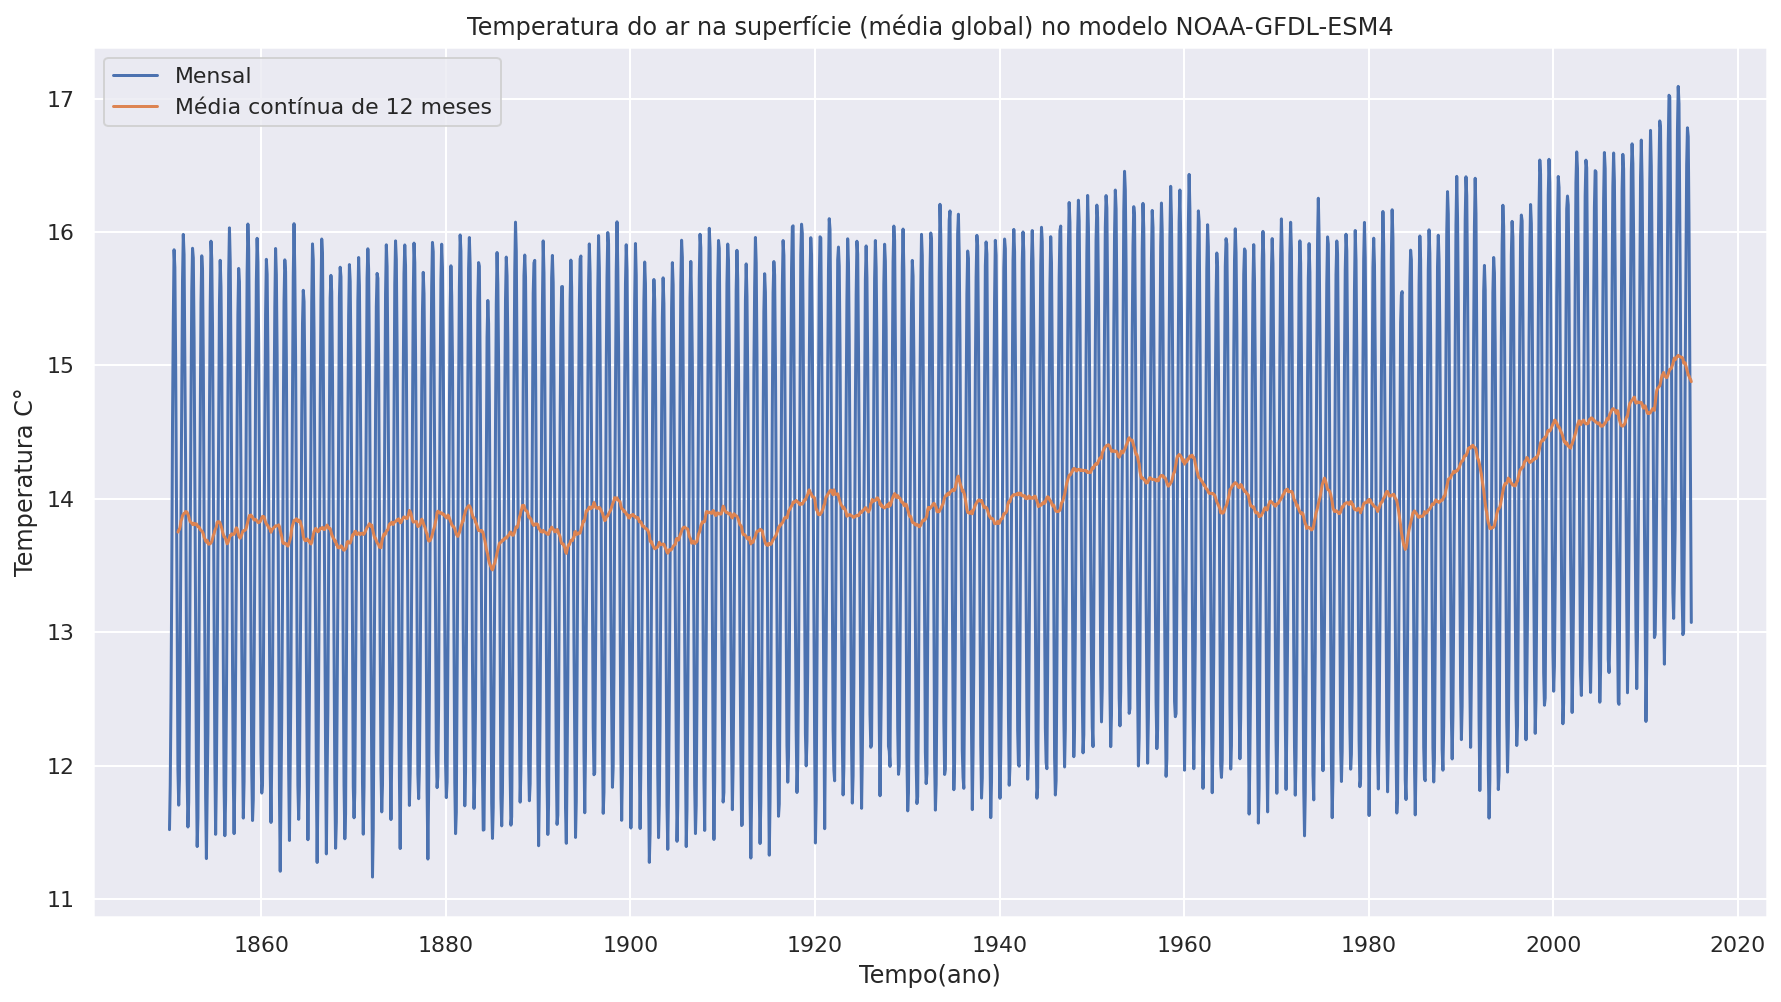

In [ ]:
sns.set_theme()
G=global_mean(ds)-273
plt.figure(figsize=(15, 8))
Med12= G.rolling(time=12).mean()
plt.xlabel('Tempo(ano)')
plt.ylabel('Temperatura C°')
plt.title('Temperatura do ar na superfície (média global) no modelo NOAA-GFDL-ESM4')
plt.plot(G.time, G.tas,label='Mensal')
plt.plot(Med12.time, Med12.tas, label='Média contínua de 12 meses')
plt.legend()



In [ ]:
NOAA_585=media12("experiment_id == 'ssp585' & source_id=='GFDL-ESM4' & variable_id == 'tas'")
NOAA_hist=media12("experiment_id == 'historical' & source_id=='GFDL-ESM4' & variable_id == 'tas'")
NOAA_126=media12("experiment_id == 'ssp126' & source_id=='GFDL-ESM4' & variable_id == 'tas'")
NOAA_anomalia= temperatura(NOAA_hist)
NOAA_anomalia

13.68553099092548

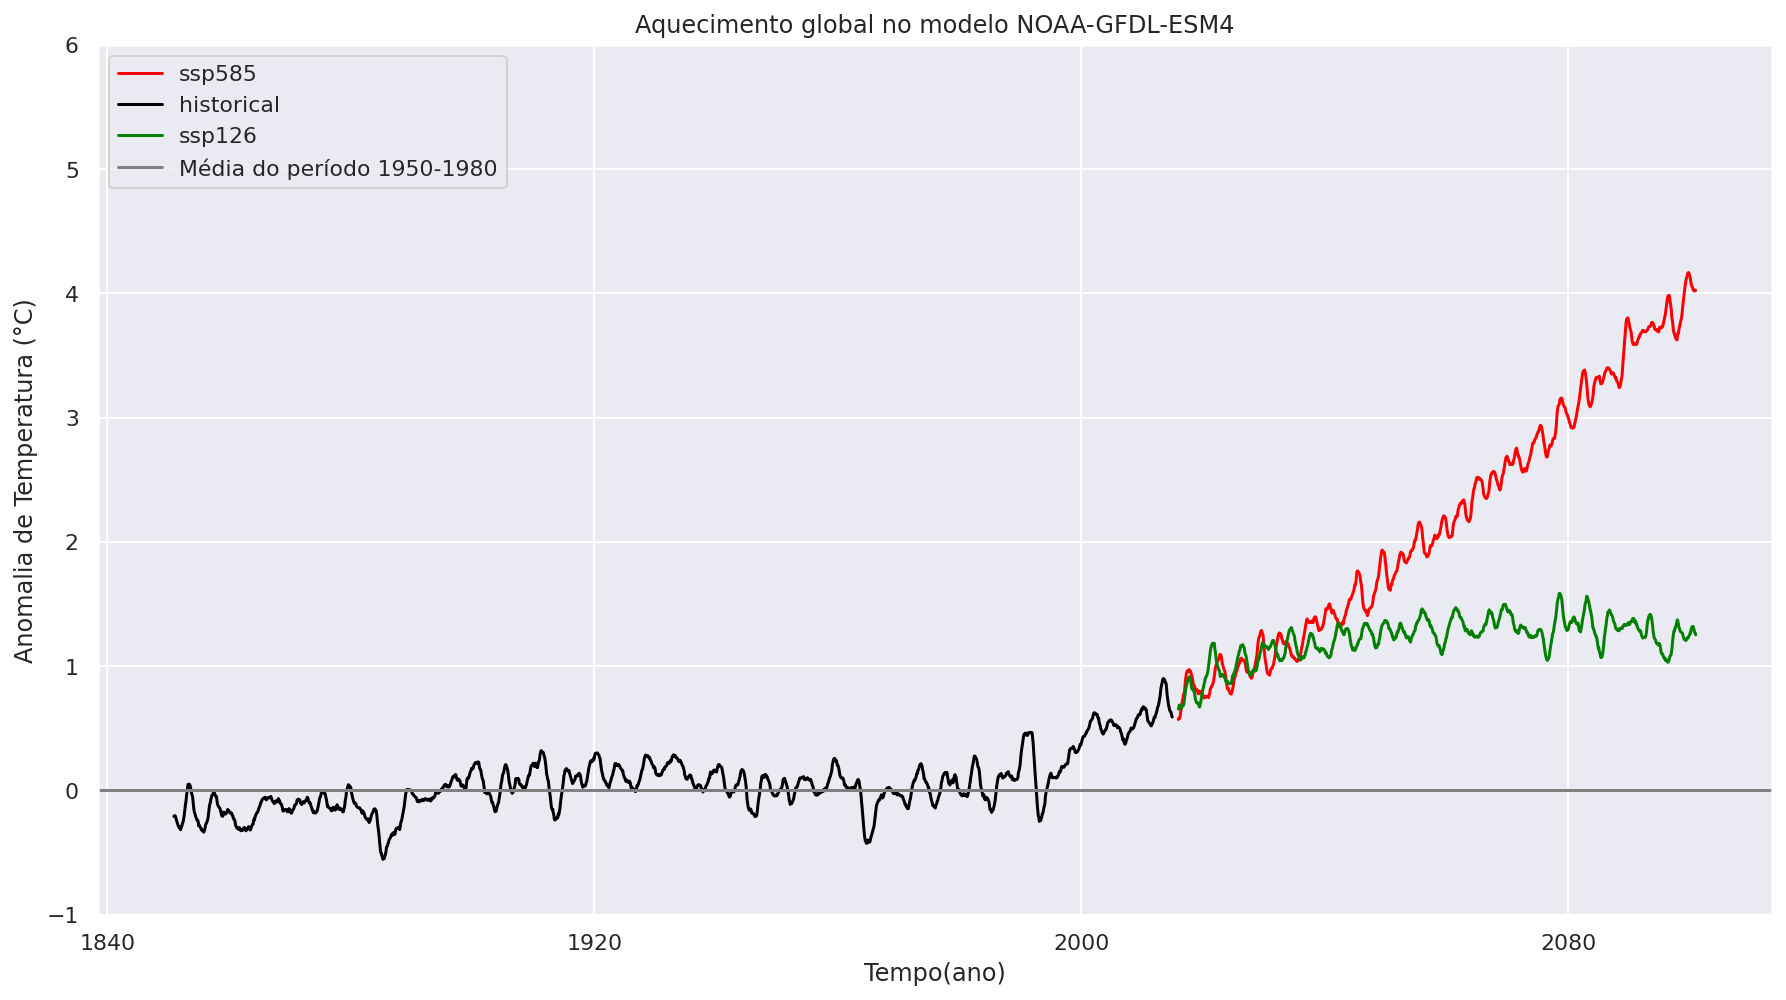

In [ ]:
sns.set_theme()
plt.figure(figsize=(15, 8))
plt.ylim(-1, 6)
plt.plot(NOAA_585.time, NOAA_585.tas-NOAA_anomalia, label='ssp585', c='red')
plt.plot(NOAA_hist.time, NOAA_hist.tas-NOAA_anomalia, label='historical', c='black')
plt.plot(NOAA_126.time, NOAA_126.tas-NOAA_anomalia, label='ssp126',c='green')
plt.axhline(0, color='gray', label='Média do período 1950-1980') 
plt.xlabel('Tempo(ano)')
plt.ylabel('Anomalia de Temperatura (°C)')
plt.title('Aquecimento global no modelo NOAA-GFDL-ESM4')
plt.legend(loc="upper left")

In [ ]:
NUIST_585=media12("experiment_id == 'ssp585' & source_id=='NESM3' & variable_id == 'tas'")
NUIST_hist=media12("experiment_id == 'historical' & source_id=='NESM3' & variable_id == 'tas'")
NUIST_126=media12("experiment_id == 'ssp126' & source_id=='NESM3' & variable_id == 'tas'")
NUIST_anomalia= temperatura(NUIST_hist)
NUIST_anomalia

14.079393755433964

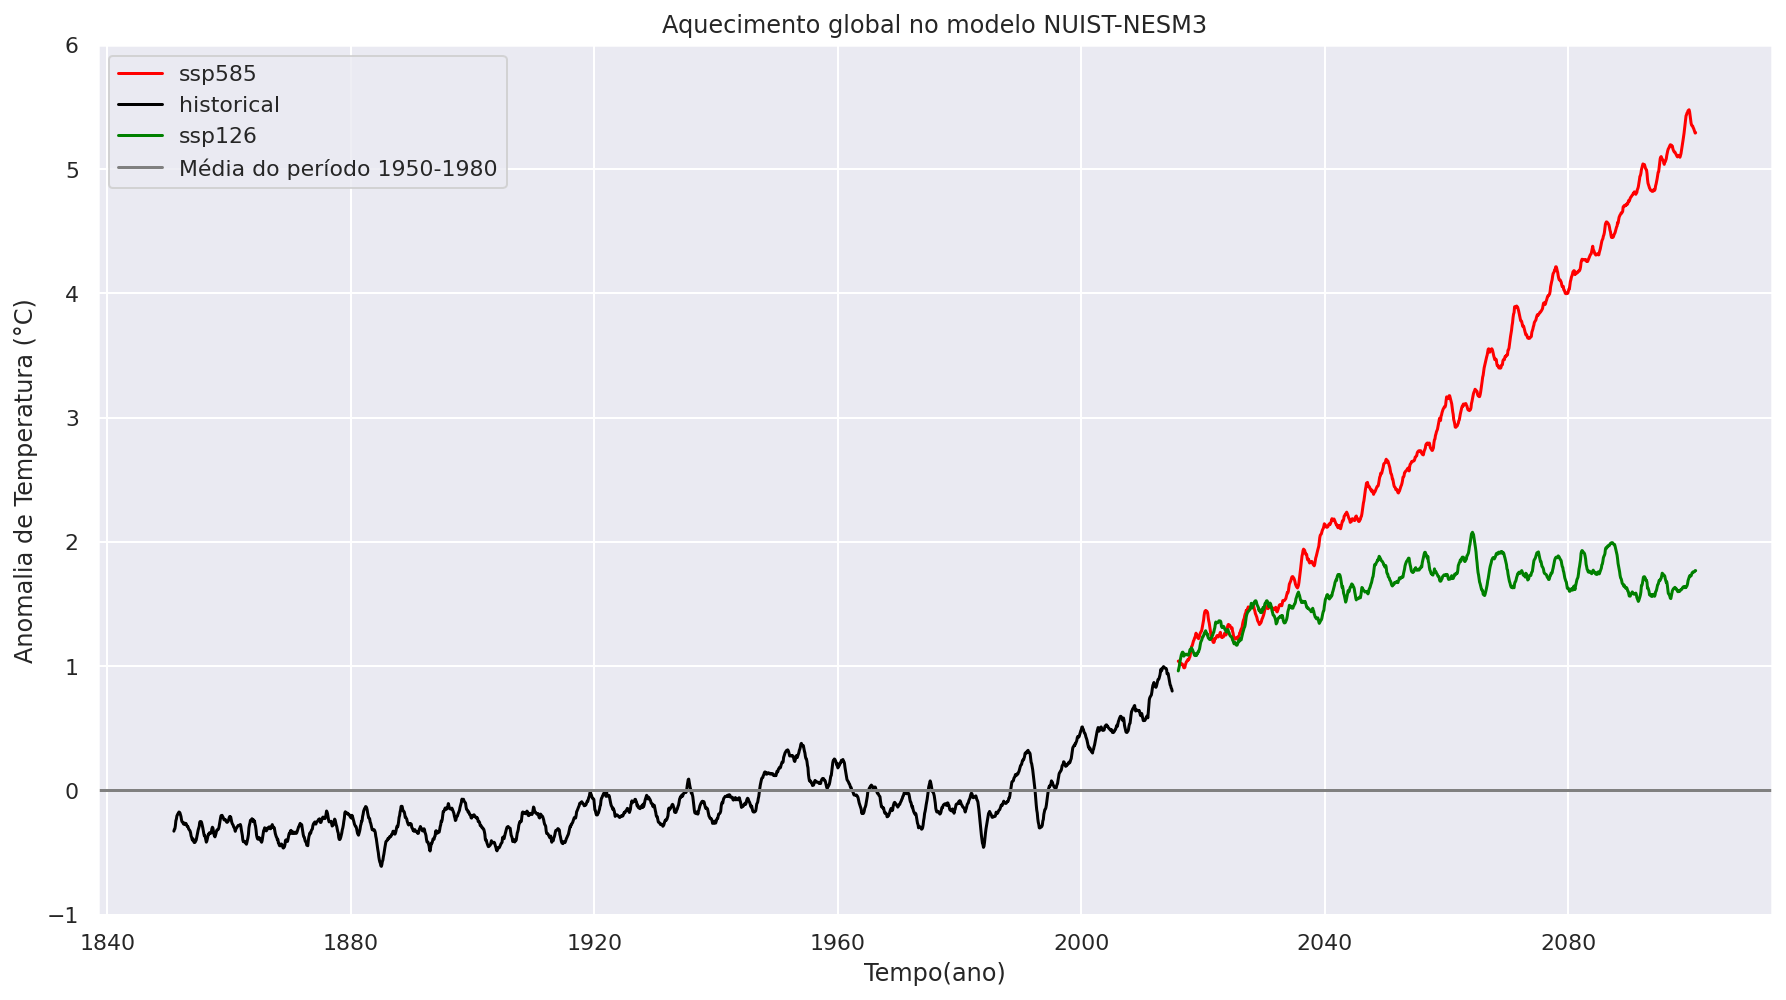

In [ ]:
sns.set_theme()
plt.figure(figsize=(15, 8))
plt.ylim(-1, 6)
plt.plot(NUIST_585.time, NUIST_585.tas-NUIST_anomalia, label='ssp585', c='red')
plt.plot(NUIST_hist.time, NUIST_hist.tas-NUIST_anomalia, label='historical', c='black')
plt.plot(NUIST_126.time, NUIST_126.tas-NUIST_anomalia, label='ssp126',c='green')
plt.axhline(0, color='gray', label='Média do período 1950-1980') 
plt.xlabel('Tempo(ano)')
plt.ylabel('Anomalia de Temperatura (°C)')
plt.title('Aquecimento global no modelo NUIST-NESM3')
plt.legend(loc="upper left")

In [ ]:
# Only land temperature averages
data1 = pd.read_csv('http://github.com/adamlamee/CODINGinK12/raw/master/data/LAND.csv', header=1).replace(to_replace="***", value=np.NaN)
data_LAND_AVG = data1.apply(lambda x: pd.to_numeric(x, errors='ignore'))

# Combined land and ocean temperature averages (LOTI: Land Ocean Temperature Index)
data2 = pd.read_csv('http://github.com/adamlamee/CODINGinK12/raw/master/data/LOTI.csv', header=1).replace(to_replace="***", value=np.NaN)
data_LAND_OCEAN_AVG = data2.apply(lambda x: pd.to_numeric(x, errors='ignore'))
# The .head(n) command displays the first n rows of the file.
data_LAND_AVG.head(5)
x = data_LAND_OCEAN_AVG['Year']
y = data_LAND_OCEAN_AVG['JanDec']


In [ ]:
pd_tas_timeseries=NOAA_hist.tas.to_pandas()
pd_atas_timeseries=pd_tas_timeseries- temperatura(NOAA_hist)
CFTimeIndex=pd_atas_timeseries.index #separação da data no formato CMIP6
datetimeindex=CFTimeIndex.to_datetimeindex() #Conversão para datatime 
tas_list=pd_atas_timeseries.to_list() #Cria uma lista
new_tas_timeserie=pd.Series(data=tas_list,name='TAS',index=datetimeindex) #nova timeserie
new_tas_timeserie_year =new_tas_timeserie.resample("1y").median()
yys=new_tas_timeserie_year.loc['1880-01':'2014-12']
yys=yys.reset_index()
ys=yys['TAS'] #separa a TAS
tempo=yys['index'] #separa a data
xx=tempo.to_list() #coloca em uma lista
xs=np.int16([date.strftime("%Y") for date in xx]).tolist() #pegue apenas o ano e ignore o dia e mês

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  after removing the cwd from sys.path.


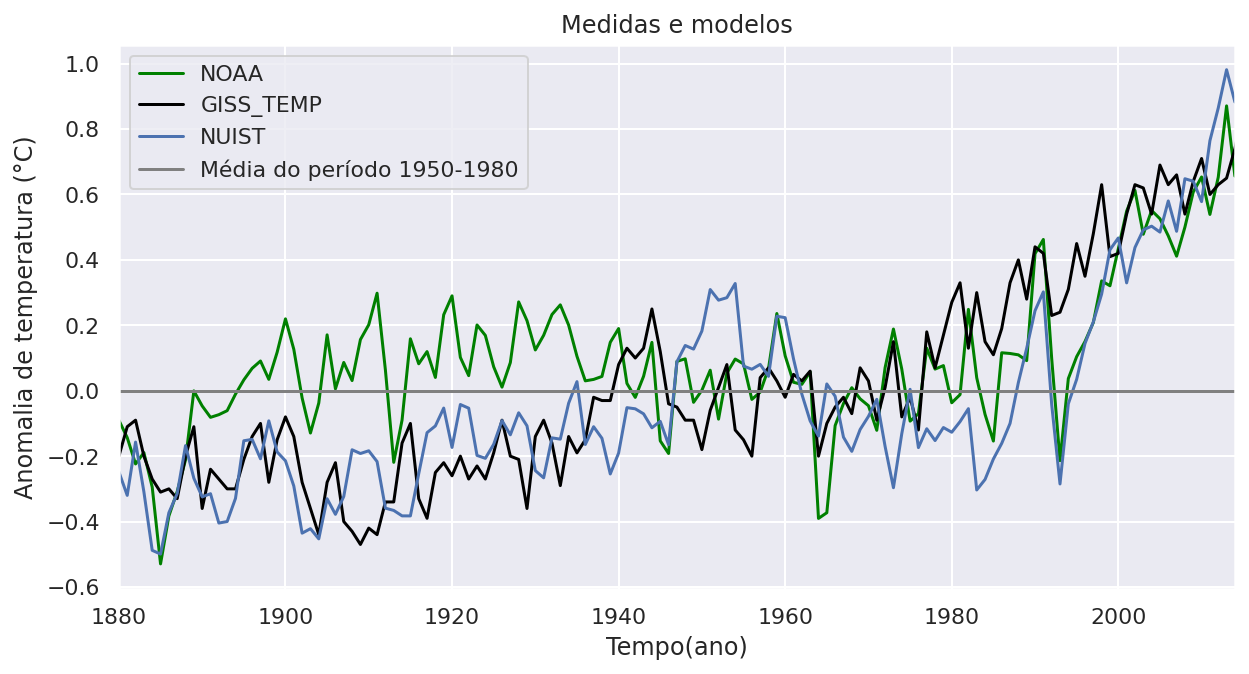

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(xs, ys, c= 'green', label='NOAA')
plt.plot(x, y, c='black',label='GISS_TEMP')
anomalias(NUIST_hist)
plt.xlim(1880, 2014)
plt.axhline(0, color='gray', label='Média do período 1950-1980')   # tente mudar a cor. No entanto, ele só conhece alguns nomes de cores.
plt.title('Medidas e modelos')
plt.xlabel('Tempo(ano)')
plt.ylabel('Anomalia de temperatura (°C)');
plt.legend()


In [ ]:
historico=mapa("experiment_id == 'historical' & source_id=='NESM3' & variable_id == 'tas'")
alto=mapa("experiment_id == 'ssp585' & source_id=='NESM3' & variable_id == 'tas'")


Gráficos de anomalia da temperatura


Text(0.5, 1.0, 'Mudança na temperatura entre 1950-1980 e 1990-2020.')

/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


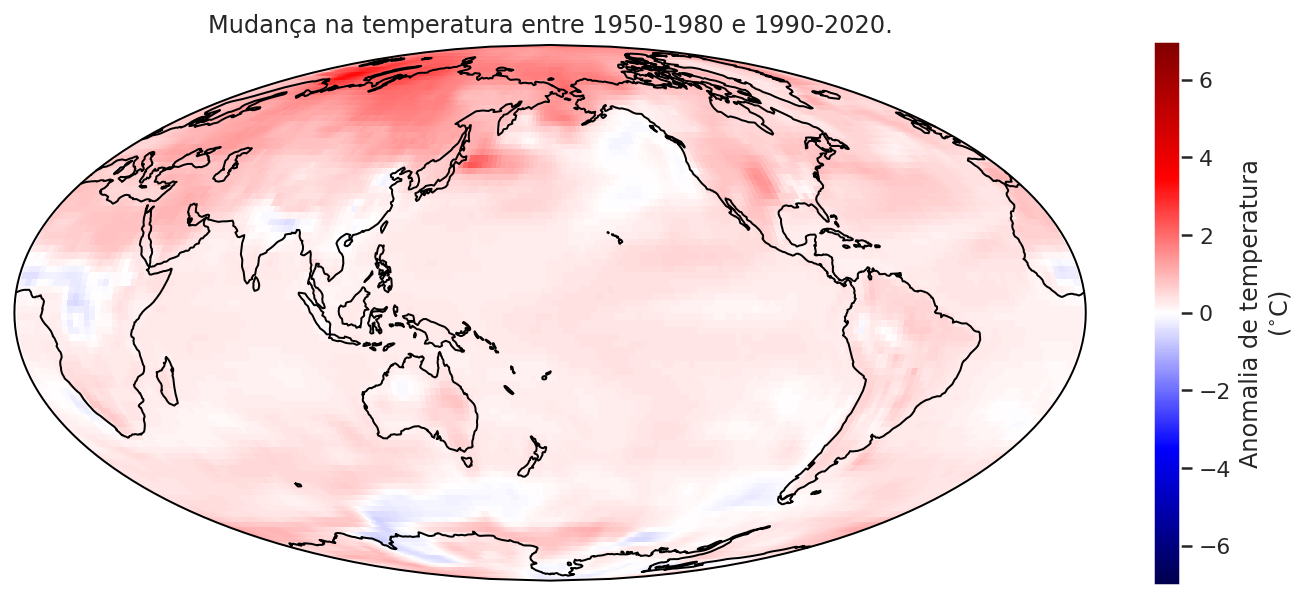

In [ ]:

temperature_change =historico['tas'].sel(time=slice('1990','2020')).mean(dim='time') -   historico['tas'].sel(time=slice('1950','1980')).mean(dim='time')

temperature_change.attrs.update(ds.attrs)
temperature_change = temperature_change.rename(
    r'Anomalia de temperatura ($^{\circ}$C)'
)
fig = plt.figure(figsize=(12, 5))
p=temperature_change.squeeze().plot(subplot_kws=dict(projection=ccrs.Mollweide(central_longitude=180.0), facecolor="gray"),
    transform=ccrs.PlateCarree(), cmap='seismic',
           vmin=-2, vmax=12, center=-5  )
p.axes.set_global()
p.axes.coastlines()
plt.title('Mudança na temperatura entre 1950-1980 e 1990-2020.')

Text(0.5, 1.0, 'Mudança na temperatura entre 1950-1980 e 2020-2050.')

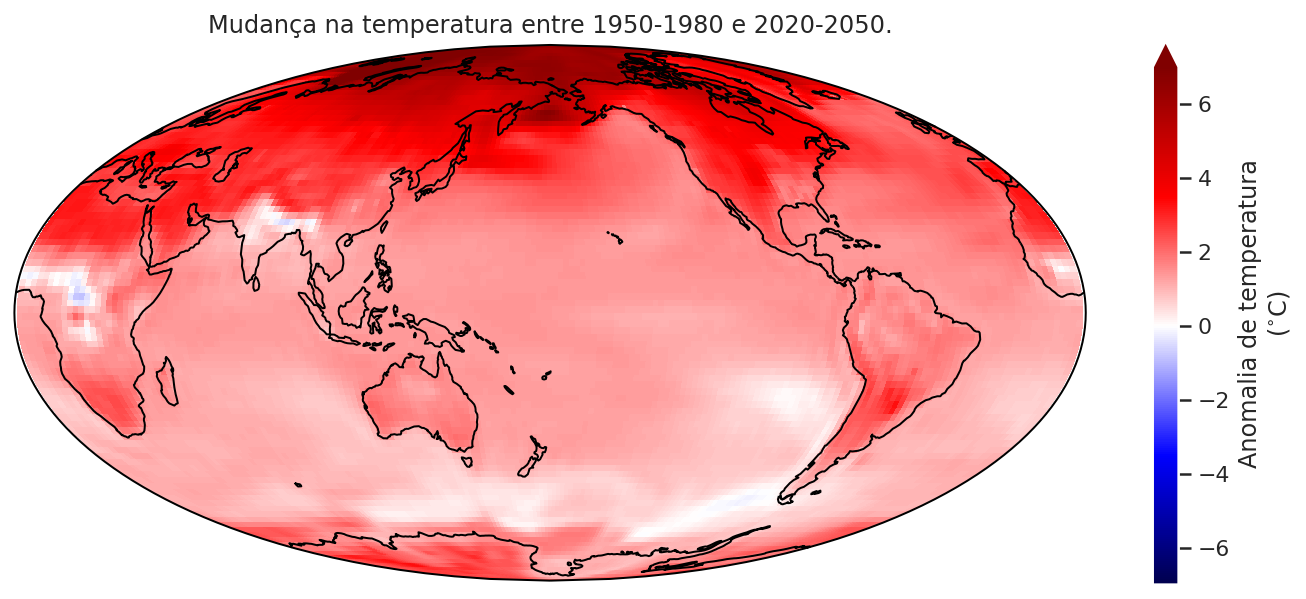

In [ ]:
temperature_change =alto['tas'].sel(time=slice('2020','2050')).mean(dim='time') -   historico['tas'].sel(time=slice('1950','1980')).mean(dim='time')

temperature_change.attrs.update(ds.attrs)
temperature_change = temperature_change.rename(
    r'Anomalia de temperatura ($^{\circ}$C)'
)
fig = plt.figure(figsize=(12, 5))
p=temperature_change.squeeze().plot(subplot_kws=dict(projection=ccrs.Mollweide(central_longitude=180.0), facecolor="gray"),
    transform=ccrs.PlateCarree(), cmap='seismic',
           vmin=-2, vmax=12, center=-5)
p.axes.set_global()
p.axes.coastlines()
plt.title('Mudança na temperatura entre 1950-1980 e 2020-2050.')

Text(0.5, 1.0, 'Mudança na temperatura entre 1950-1980 e 2050-2080.')

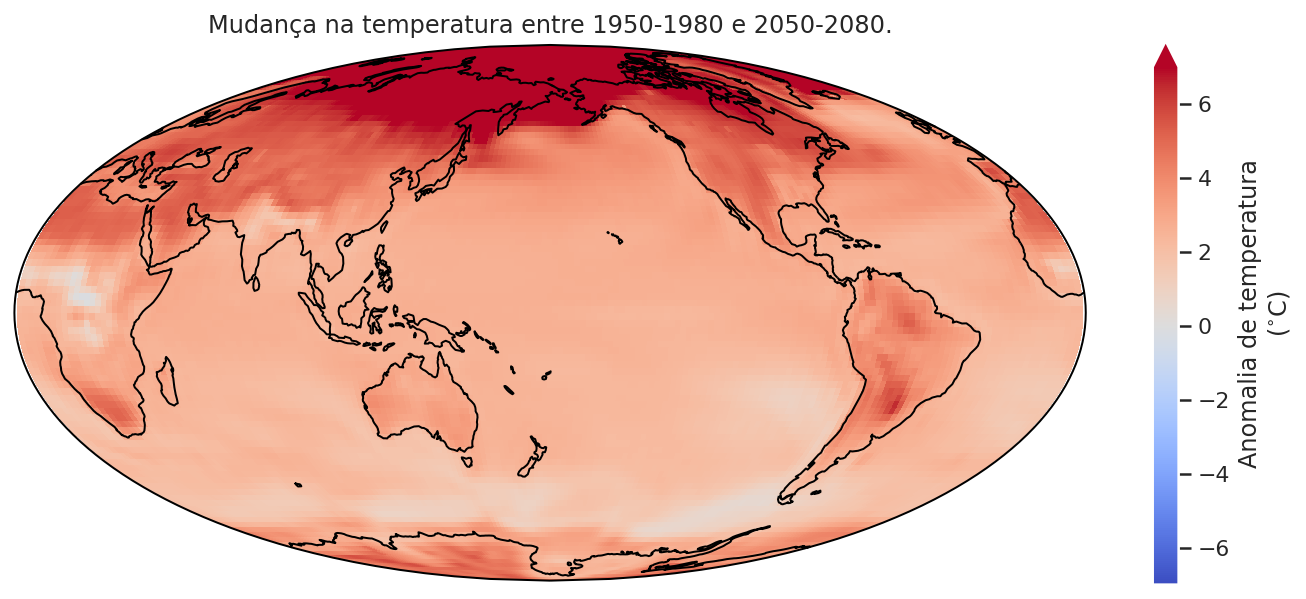

In [ ]:
temperature_change =alto['tas'].sel(time=slice('2050','2080')).mean(dim='time') -   historico['tas'].sel(time=slice('1950','1980')).mean(dim='time')

temperature_change.attrs.update(ds.attrs)
temperature_change = temperature_change.rename(
    r'Anomalia de temperatura ($^{\circ}$C)'
)
fig = plt.figure(figsize=(12, 5))
p=temperature_change.squeeze().plot(subplot_kws=dict(projection=ccrs.Mollweide(central_longitude=180.0), facecolor="gray"),
    transform=ccrs.PlateCarree(), cmap='coolwarm',
           vmin=-2, vmax=12, center=-5)
p.axes.set_global()
p.axes.coastlines()
plt.title('Mudança na temperatura entre 1950-1980 e 2050-2080.')

Text(0.5, 1.0, 'Temperatura média do NESM3 entre 1950-1980 ')

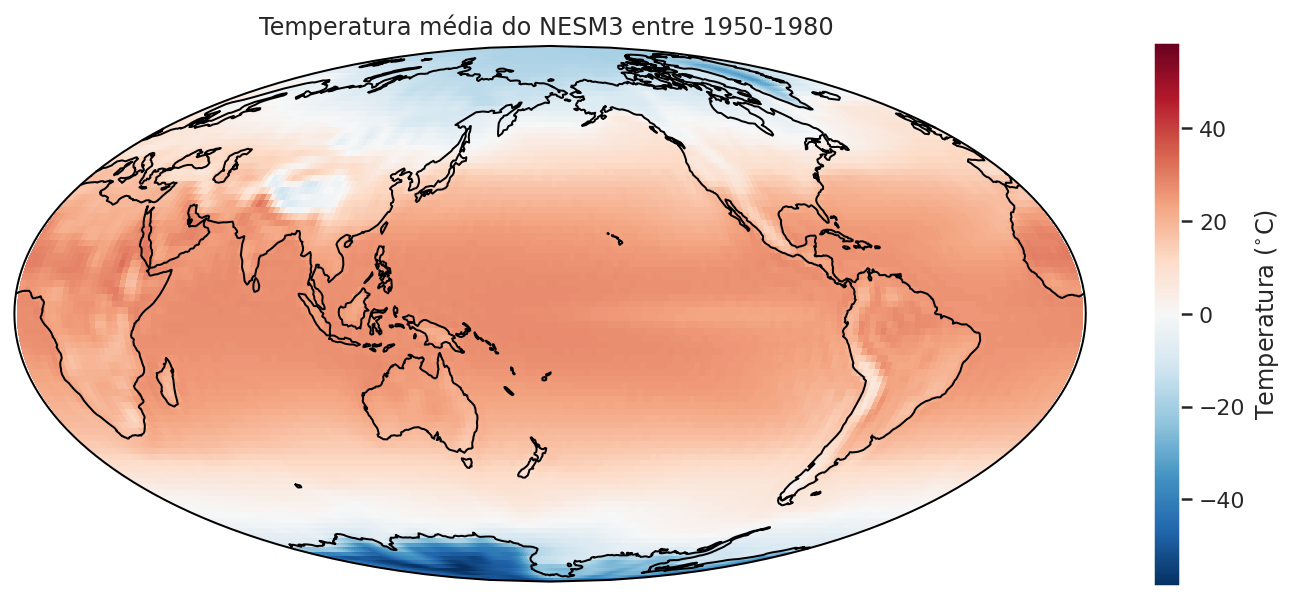

In [ ]:
temperature_change = historico['tas'].sel(time=slice('1950','1980')).mean(dim='time')-273

temperature_change.attrs.update(ds.attrs)
temperature_change = temperature_change.rename(
    r'Temperatura ($^{\circ}$C)'
)
fig = plt.figure(figsize=(12, 5))
p=temperature_change.squeeze().plot(subplot_kws=dict(projection=ccrs.Mollweide(central_longitude=180.0), facecolor="gray"),
    transform=ccrs.PlateCarree())
p.axes.set_global()
p.axes.coastlines()
plt.title('Temperatura média do NESM3 entre 1950-1980 ')

Text(0.5, 1.0, 'Mudança na temperatura entre 1950-1980 e 2070-2100.')

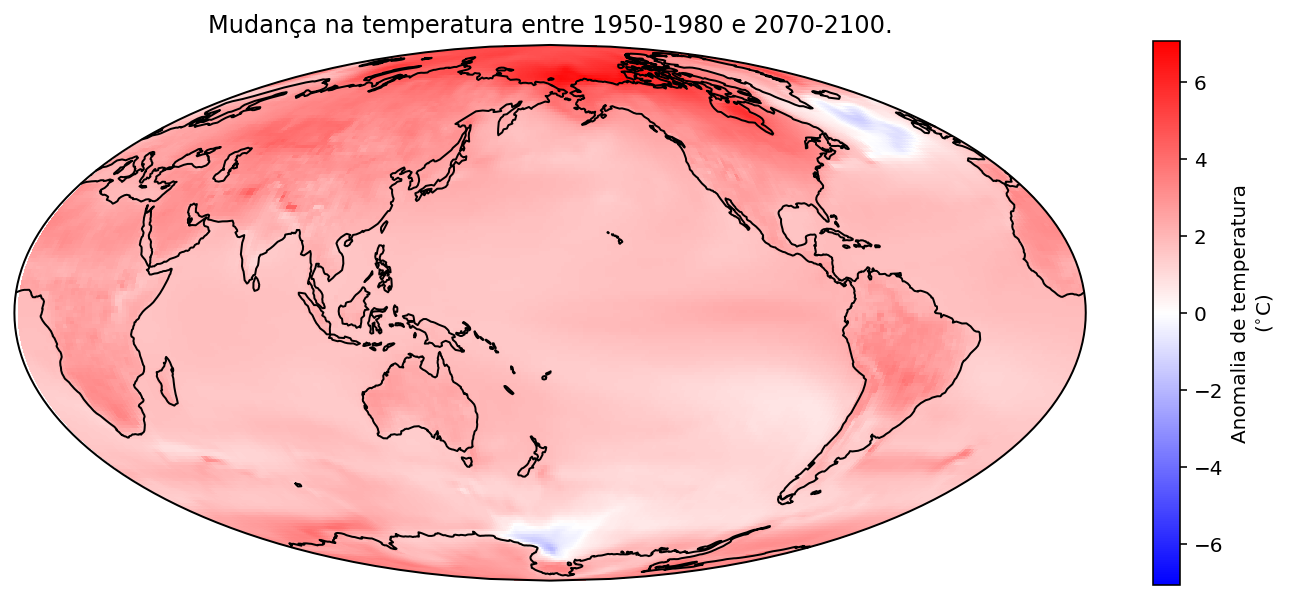

In [ ]:
temperature_change =alto['tas'].sel(time=slice('2070','2100')).mean(dim='time') -   historico['tas'].sel(time=slice('1950','1980')).mean(dim='time')

temperature_change.attrs.update(ds.attrs)
temperature_change = temperature_change.rename(
    r'Anomalia de temperatura ($^{\circ}$C)'
)
fig = plt.figure(figsize=(12, 5))
p=temperature_change.squeeze().plot(subplot_kws=dict(projection=ccrs.Mollweide(central_longitude=-180.0), facecolor="gray"),
    transform=ccrs.PlateCarree(), cmap='bwr',
           vmin=-2, vmax=12, center=-5)
p.axes.set_global()
p.axes.coastlines()
plt.title('Mudança na temperatura entre 1950-1980 e 2070-2100.')

Comparando 'america do sul' e o resto do mundo


In [ ]:
historico=mapa("experiment_id == 'historical' & source_id=='NESM3' & variable_id == 'tas'")
alto=mapa("experiment_id == 'ssp245' & source_id == 'NESM3' & variable_id == 'tas'")
G=america12(historico)
H=america12(alto)
pd_tas_timeseries=G.to_pandas() # Transformando xarray para pandas
tasm=pd_tas_timeseries.loc['1951-01':'1980-12'].mean()


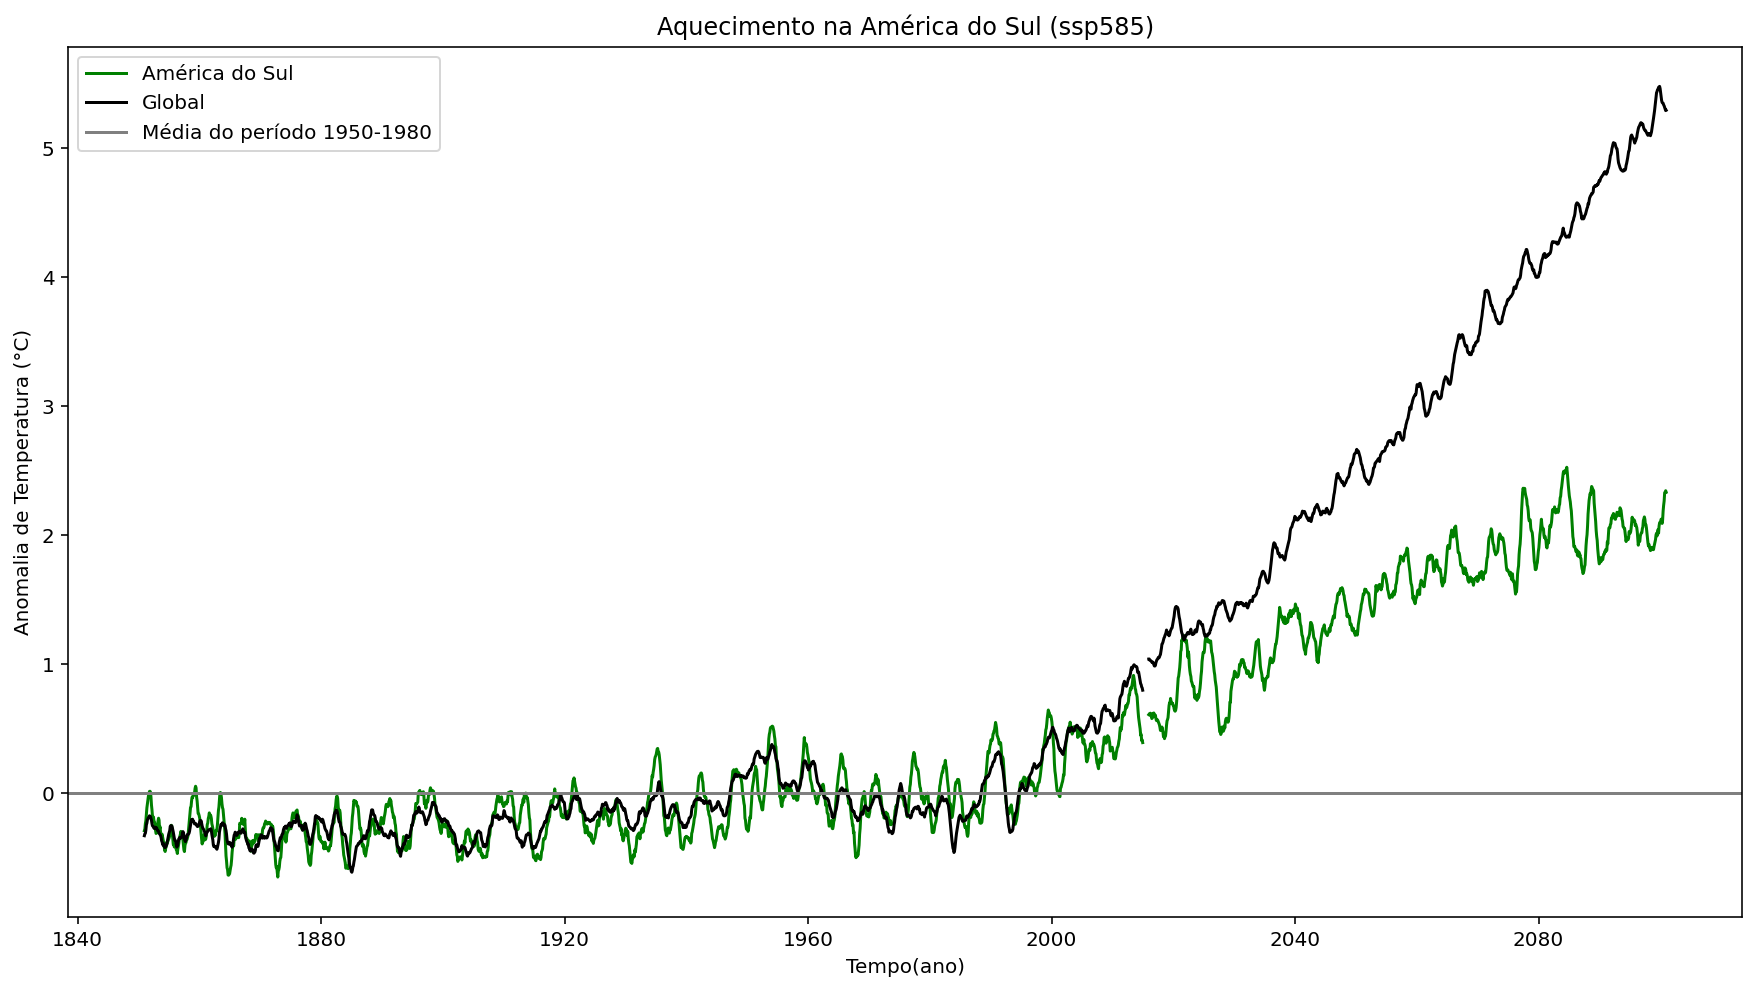

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(G.time, G.values-tasm, label='América do Sul', c='green')
plt.plot(H.time, H.values-tasm, c='green')
plt.plot(NUIST_585.time, NUIST_585.tas-NUIST_anomalia, c='black')
plt.plot(NUIST_hist.time, NUIST_hist.tas-NUIST_anomalia, label='Global', c='black')
plt.axhline(0, color='gray', label='Média do período 1950-1980') 
plt.title('Aquecimento na América do Sul (ssp585)')
plt.xlabel('Tempo(ano)')
plt.ylabel('Anomalia de Temperatura (°C)');
plt.legend()
